## Epileptic Seizure Recognition Dataset - Clustering

The goal for this analysis is to classify the data using clustering as well as identify any noise in the dataset by using anomaly detection. The dataset is an epileptic seizure recognition dataset developed by Rochester Institute of Technology (RIT). It was edited from the original by removing the row indices of the dataset. The dataset contains 179 columns with 178 being EEG recordings and the last column being a class label. The subjects in Class 1 have had an epileptic seizure, the others have not. The original dataset as well as more information can be found [here](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

### Set up Environment 

In [111]:
# import libraries 
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import random as rand
import itertools as it
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

%matplotlib inline
warnings.simplefilter("ignore")

### Read in Data 

In [4]:
# read in data 
data = pd.read_csv("seizure_edited.csv", header = 0)

# preview data 
print(data.info())
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.7 MB
None


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
8813,118,106,49,0,-29,-11,13,53,63,78,...,-7,17,5,-5,-18,-1,4,-8,-21,3
1975,-12,-12,-14,-45,-62,-60,-72,-86,-85,-89,...,-36,-45,-56,-61,-76,-88,-92,-120,-137,4
9566,-109,-159,-127,-41,155,313,379,331,251,192,...,-121,-136,-161,-177,-189,-199,-200,-186,-154,1
1419,-101,-67,-20,11,22,23,2,-11,-7,20,...,57,84,117,136,167,182,186,178,170,1
3027,118,121,114,106,104,93,91,68,49,26,...,96,89,88,91,92,92,89,70,70,3
8501,-67,-66,-68,-64,-59,-59,-52,-55,-53,-56,...,-85,-81,-85,-83,-81,-82,-85,-91,-94,3
585,-25,-33,-49,-67,-61,-35,-10,5,10,7,...,-38,1,39,54,35,20,6,-8,-33,5
4407,51,46,4,-35,-44,-37,-44,-35,-21,1,...,-70,-96,-105,-128,-133,-109,-71,-33,-4,4
5920,59,53,38,30,18,10,-2,-13,-16,-15,...,28,26,30,31,32,37,41,40,39,2
4158,-80,-73,-80,-81,-75,-58,-51,-37,-17,-30,...,71,82,96,109,119,123,125,131,138,1


### Data Preprocessing 

Now, the data needs needs to be separated in feautures and labels. 

In [6]:
# split features and labels 
features = data.drop('y', axis = 1)
labels = data['y']

#### Principal Component Analysis (PCA)

The algorithms that  will be used in the following analyses (KMeans and DBSCAN) are both sensitive to high dimensions, which means the dimensionality of the dataset needs to be reduced. Before a PCA can be ran, the dataset also needs to be standardized.

In [8]:
# create scaler 
scaler = StandardScaler() 

# standardize data
features_scaled = scaler.fit_transform(features) 

# create PCA + reduce dimensions
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(features_scaled) 

# convert to pandas dataframe 
features_pca = DataFrame(pca_data)
features_pca.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
4836,1.212238,0.604534,0.334454,0.555663,0.371883,0.122969,-0.319166,-2.124218,0.250540,0.458442,...,0.706499,-0.445851,0.002639,-0.202294,0.406615,0.416603,0.498767,-0.114007,0.265183,-0.933575
3986,-0.590003,0.342209,-0.426548,0.168683,0.749959,-1.385532,-0.372951,-1.932212,0.380238,-0.624246,...,-0.182167,-0.051068,-0.023797,-0.068018,0.039964,-0.019700,0.029371,-0.159077,-0.080117,-0.081091
2145,-0.201302,0.346062,-0.790442,0.499772,-1.166722,1.370381,0.847840,-1.539197,0.608500,0.763990,...,0.385647,-1.307432,-0.036839,-1.553822,-0.025933,0.905580,-0.613214,-0.256001,-0.091575,-0.194591
9705,-0.624325,0.387759,-0.449541,0.045248,0.190930,-0.373379,0.306794,-0.182885,-0.226894,1.986667,...,0.036419,0.282690,-0.270351,-0.663828,-0.412651,-0.523704,0.093337,-0.086397,0.260703,-0.447199
7507,-0.858041,0.503430,0.605744,-0.060030,0.212819,1.039206,1.018620,0.062349,1.489329,-0.864747,...,-0.141994,0.021123,0.039071,0.679387,0.197756,-0.067229,-0.007711,0.321167,0.054545,-0.235221
1749,0.916736,-6.087350,-15.019204,1.340906,-6.541718,-1.647581,6.209907,-1.176663,-2.784332,-4.119325,...,-1.765738,1.052428,-2.943924,0.346856,0.866307,0.330657,1.027321,1.019293,-0.954010,-2.127102
10905,6.613149,2.442413,-7.823533,1.649736,-2.480156,-6.088961,-3.188080,1.495616,-6.022294,-0.175999,...,1.684278,3.593287,-0.756882,1.838640,1.641115,2.191984,0.499331,0.316461,-0.111647,-1.663154
296,-0.528455,2.635543,-6.207663,0.516478,5.977482,1.250329,7.203396,-0.088447,3.683717,1.321793,...,3.664537,-0.734278,3.334075,-3.826520,-1.449778,2.214760,0.646193,-0.433647,-0.397953,0.737161
6703,0.028966,-0.460058,0.121935,0.460551,-0.816799,1.741706,-0.619198,1.596172,0.870657,0.695046,...,0.060192,-0.421901,-0.165423,-0.198471,0.205899,-0.008940,0.173870,0.422046,-0.093181,-0.050084
2347,0.366709,0.124063,0.585442,-0.371038,0.663752,-0.626708,-0.168050,0.088990,1.547855,-0.088564,...,0.010846,0.013943,0.077339,0.165150,0.294563,0.167420,0.094220,0.167684,0.008289,0.049898


### Scatterplot  

Since the data is multidimensional, it needs to be reduced to two dimensions in order to be able to plot it. For conveniece, the following function was created to reduce the dimensionality of the dataset and plotting it by only taking in the features and labels. 

In [9]:
# create 2d scatterplot 
def scatter(data, labels, points = 300):
    
    entries = data.shape[0]
    start = rand.randint(0, entries - points)
    end = start + points
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    # create mds 
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    
    # plot 
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

### Clustering

Now that the dimensionality of the data has been reduced, it can now be clustered. The three clustering methods that will be used are DBSCAN, KMeans, and Hierarchical. 

#### Density-Based Spatial Clustering of Applications with Noise (DBSCAN) 

DBSCAN finds core samples of high density and creates clusters from them. To use this algorithm, a MinPts and Eps needs to be set. For this analysis, MinPts = 4 and Eps will be determined by plotting the distance of every point to the 4th nearest neighbor and finding the bend in the graph. 

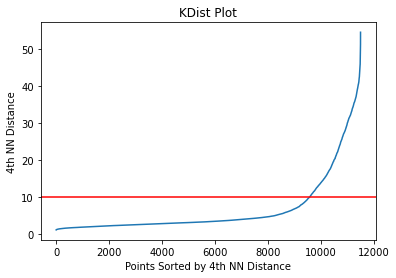

In [73]:
# create nearest neighbords + fit data 
nn = NearestNeighbors(n_neighbors=4) 
nn.fit(features_pca) 

# get distances 
dist, ind = nn.kneighbors(n_neighbors=4) 
dist = sorted([d[3] for d in dist])

# plot 
plt.plot(dist)
plt.title('KDist Plot')
plt.xlabel('Points Sorted by 4th NN Distance')
plt.ylabel('4th NN Distance')
plt.axhline(y=10, color='r')
plt.show()

Looking at the k-dist plot, the 'bend' in the chart is around 10, so lets make Eps=10. 

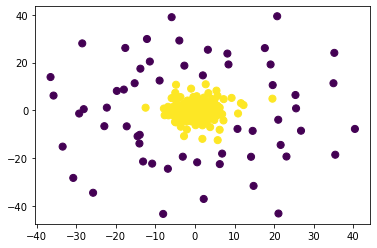

In [74]:
# create dbscan 
dbscan = DBSCAN(eps=10, min_samples=4)

# predict values 
predict = dbscan.fit_predict(features_pca) 

# plot 
scatter(features_pca, Series(predict)) 

In [86]:
# group by and count 
(unique, counts) = np.unique(predict, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  -1 1778]
 [   0 9718]
 [   1    4]]


The DBSCAN algorithm split the data into three different clusters (-1, 0, and 1) because the DBSCAN algorithm identifies outliers as well. Now, let's try clustering with KMeans. 

#### K-Means

The K-means algorithm clusters data by separating it into separate samples in n groups of equal variance. The algorithm requires the number of clusters to be specificed first. To choose the correct k, silhouette coefficients need to be generated to be able to pick the best one. The silhouette coefficient is higher (closer to 1) when clusters are dense and well separated, which is the goal. 

In [100]:
# generate silhouette scores for k, 2-5 
sscores = []
for k in range(2, 6): 
    km = KMeans(k, random_state=4)
    predict = km.fit_predict(features_pca) 
    sscore = silhouette_score(features_pca, predict) 
    sscores.append(sscore)
    print(f'silhouette score (k={k}): {sscore}')

silhouette score (k=2): 0.07311467358203473
silhouette score (k=3): 0.07024237533503609
silhouette score (k=4): 0.08681804374725222
silhouette score (k=5): 0.0819406633497277


K = 4, silhouette score = 0.08681804374725222


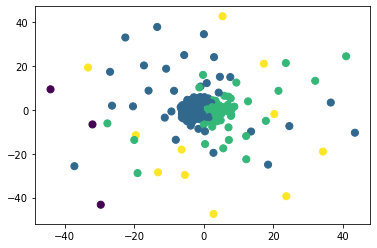

In [104]:
# find best k 
k = sscores.index(max(sscores)) + 2

# plot 
km = KMeans(k, random_state=4)
predict = km.fit_predict(features_pca) 
print(f'K = {k}, silhouette score = {max(sscores)}')
scatter(features_pca, Series(predict))

For KMeans clustering, the best k = 4. However, when plotted, the clusters are not the most distinct, which is even supported by the silhouette score. 

#### Hierarchical 

Hierarchical clustering great for data with an underlying hierarchy, but it is expensive in both time and space. For the purpose of this analysis, the given code is used to downsample the data. Once downsampled, the cophenetic distance will be calculated to determine the best linkage method, which will then be plotted. 

In [108]:
# stratified downsample  
def downsample_data(data):
    downData = None
    downLabels = None

    kfold = StratifiedKFold(n_splits = 100)
    for throwAway_index, subsample_index in kfold.split(data, labels):
        downData = data.iloc[subsample_index]
        downLabels = labels.iloc[subsample_index]
        break

    return downData

single: 0.9889267562252901
complete: 0.9365460775733229
average: 0.9908940882254501
centroid: 0.991063363686008
ward: 0.9166897879973146


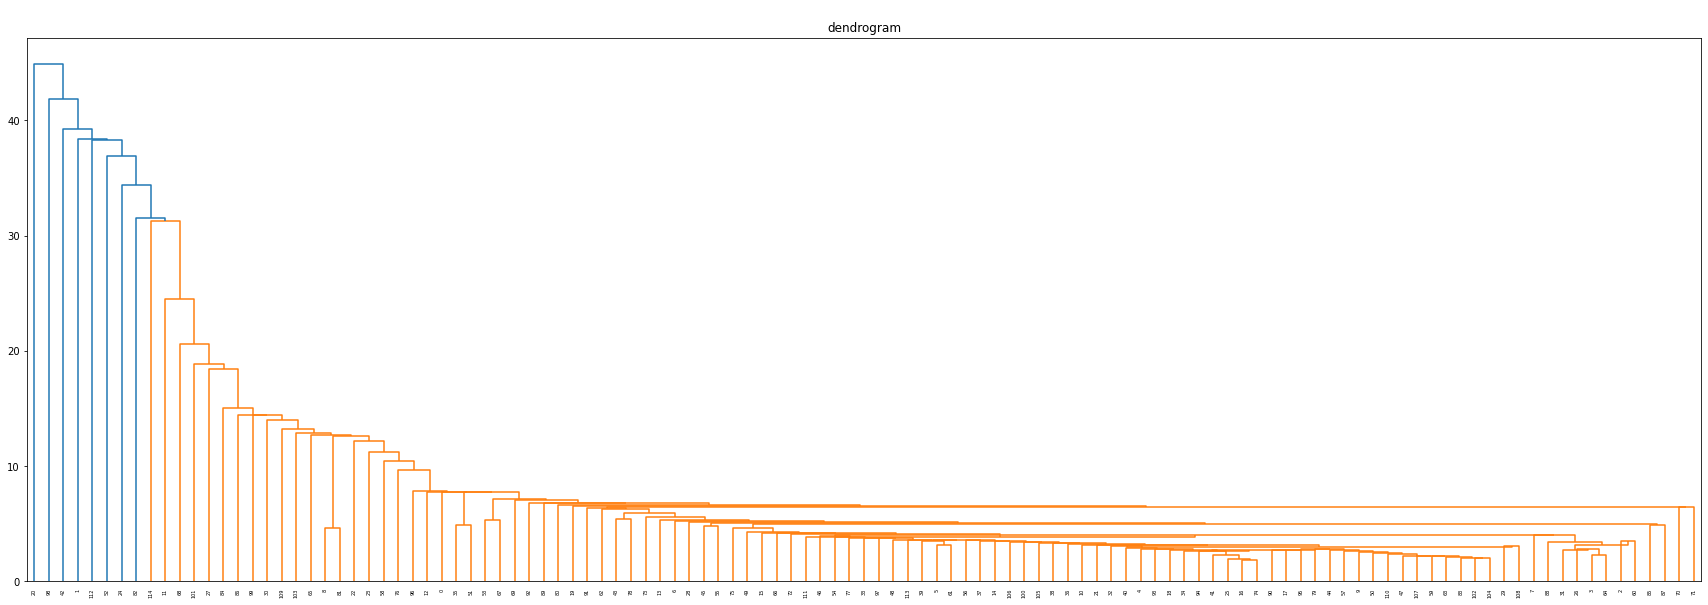

In [136]:
# downsample data 
down_data = downsample_data(features_pca) 

# get proximity matrix 
pmatrix = pdist(down_data)

# linkage methods 
links = [] 
methods = ['single', 'complete', 'average', 'centroid', 'ward']

# generate linkages 
for method in methods: 
    link = linkage(down_data, method)
    dist, mat = cophenet(link, pmatrix) 
    links.append((link, dist))
    print(f'{method}: {dist}')
    
# get cpcc and index 
cpcc = [x[1] for x in links]
idx = cpcc.index(max(cpcc))
    
# plot best linkage method 
plt.figure(figsize=(30, 10))
plt.title('\ndendrogram')
dendrogram(links[idx][0]);

The centroid method ended up being the method with the best score, which was the method used to plot the above dendrogram. 